# Wstęp do matematyki finansowej 
## Laboratorium 1.

In [3]:
import math
import random
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

### Zadanie 3.a
Zaimplementuj liniowy generator dla $k = 1$, $m = 2^{35}$, $a_{1} = \lfloor \pi * 10^{9} \rfloor$ oraz $a_{0} = \lfloor e * 10^{9} \rfloor$  
i wygeneruj na jego podstawie dużo liczb z przedziału [0, 1]. Obejrzyj histogram.

In [4]:
def LCG(N, m = 2**35, a0 = math.floor(math.e * 10**9), a1 = math.floor(math.pi * 10**9)):
    """ 
    Linear congruential generators (LCG) 
    """
    # setting the seed
    seed = np.random.randint(1e3)
    
    LCG.current = seed
    rand = []
    
    for i in range(N):    
        LCG.current = (a1*LCG.current + a0) % m
        rand.append(LCG.current/(m-1))
    return rand

In [5]:
N = int(1e6)
sample = LCG(N)
np.array(sample)

array([0.90267032, 0.34599373, 0.74338334, ..., 0.28010627, 0.12482574,
       0.23714056])

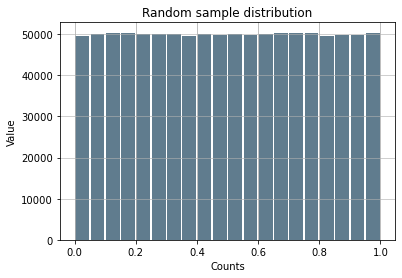

In [6]:
sample = pd.Series(sample)
sample.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Random sample distribution')
plt.xlabel('Counts')
plt.ylabel('Value')
plt.grid(axis='y', alpha=0.75)

### Zadanie 3.b
Korzystając z metody eliminacji (lub jej modyfikacji), wygeneruj zmienne losowe z rozkładu o gęstości:  
$$
  f(x) = \frac{1+\cos(2 \pi x)}{1+e^{-2\pi^{2}}} \frac{e^{-x^{2}/2}}{\sqrt{2\pi}}
$$

#### 1. Metoda eliminacji
**Komentarz:** Po implementacji zorientowałam się, że metoda ta nie jest adekwatna, ponieważ wykres gęstości $f$ nie mieści się w prostokącie $[a,b]×[0,d]$ !!! Poniżej jest implementacja modyfikacji funkcji eliminacji, która jest odpowiednia dla zadanego problemu.

In [7]:
def pdf(x):
    """
    Probability density function
    """
    return (1 + np.cos(2*math.pi*x))/(1 + np.exp(-2*math.pi**2))*(np.exp(-x**2/2)/np.sqrt(2*math.pi))

In [8]:
def rejection_method(a, b, pdf, N = 1):
    """
    Rejection method for random number generation  
    """
    
    N = int(N)
    
    # Extreme values of the PDF in the desired interval
    x = np.linspace(a, b, 10000)
    y = pdf(x)
    d = y.max()
    
    # Counter
    naccept = 0
    
    accepted = []

    while(naccept < N):
        X = np.random.uniform(a, b, N)
        Y = np.random.uniform(0.0, d, N)
        
        negs = np.empty(N)
        negs.fill(-1)
        variables = np.where(Y <= pdf(X), X, negs) 

        to_append = np.extract(variables >= 0.0, variables)
        accepted = np.append(accepted, to_append)
        naccept += len(to_append)
    
    return(accepted[:N])


In [9]:
a = 0  # xmin
b = 5.  # xmax
N = int(1e6)

sample = rejection_method(a, b, pdf, N)
sample

array([0.89157905, 1.2935347 , 0.1285186 , ..., 0.11746464, 0.70607327,
       0.02490364])

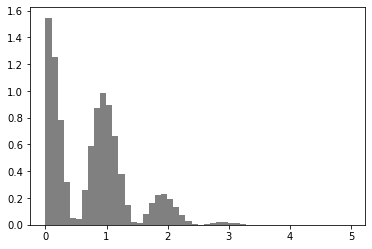

In [10]:
plt.hist(sample, bins = 50, color = 'grey', density = True)
plt.show()

#### 2. Modyfikowana metoda eliminacji
Adekwatna dla rozważanej funkcji gęstości (nie mieszczącej się w prostokącie $[a,b]×[0,d]$)

$$
  f(x) = \frac{1+\cos(2 \pi x)}{1+e^{-2\pi^{2}}} \frac{e^{-x^{2}/2}}{\sqrt{2\pi}}
$$

Mianownik pierwszego składnika iloczynu jest większy od 1 a licznik zawiera się w przedziale [0, 2].
Drugi składnik jest formułą gęstości rozkładu standardowego normalnego $N(0, 1)$.   

Stąd stosuję metody eliminacji z modyfikacją, gdzie $g(x)$ będzie gęstością rozkładu normalnego z parametrami $\mu = 0$ i $\sigma = 1$, $a = 2$, $g(x) = \frac{e^{-x^{2}/2}}{\sqrt{2\pi}}$

In [11]:
# gęstość, której nie umiemy generować
def g(x):
    return ((1 + math.cos(2 * math.pi * x)) / (1 + math.exp(-2*math.pi**2)))*((math.exp(-x**2/2)) / math.sqrt(2*math.pi))

In [12]:
def f(x):
    return math.exp(-x**2/2) / math.sqrt(2*math.pi)

In [34]:
def modif_rejection_method():
    a = 2
    i = 0
    while(i < 1e6):
        x = random.gauss(0, 1)
        # określenie górnej granicy przedziału rozkładu jednostajnego
        # jest równoważne losowaniu z przedziału [0, 1] i przeskalowaniu f(x) przez a*g(x)
        y = random.uniform(0, a * f(x))
        if y <= g(x):
            return x
        i += 1

In [35]:
sample = [modif_rejection_method() for i in range(int(1e6))]   
np.array(sample)

array([-0.98206578,  1.05870897, -0.9645775 , ...,  1.00891869,
       -1.93778519,  1.26308142])

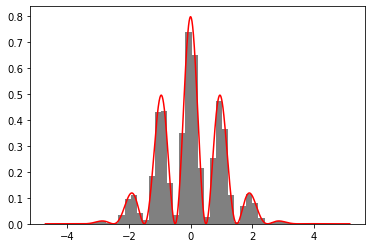

In [36]:
plt.hist(sample, bins = 50, color = 'grey', density = True)

xmin = min(sample)
xmax = max(sample)
x = np.linspace(xmin, xmax, 2000)
plt.plot(x, np.vectorize(g)(x), color='red')

plt.show()

### Zadanie 3.c
Wygeneruj ciąg zmiennych losowych z rozkładu Poissona. Na dwa sposoby, ale nie korzystaj z wbudowanego algorytmu!

#### Sposób 1.

In [14]:
def poiss(lamb, N = 1):
    
    """
    General algorithm for generating numbers from the discrete 
    distribution (in particular, the Poisson distribution)
    """
    
    rand = []
    N = int(N)
    
    for i in range(N):
        n = 0
        power = 1
        U = np.random.uniform(0, 1)
        prev_prob = np.exp(-lamb) # P(X = 0) = exp(-lambda)

        while(U > prev_prob):
            n += 1
            current_prob = (math.pow(lamb, n) / math.factorial(n)) * np.exp(-lamb) # P(X = n)
            prev_prob = prev_prob + current_prob # prev_prob = prev_prob + P(X = n)
        
        rand.append(n)
    return rand

In [15]:
lamb = 10
sample = poiss(lamb, N)
np.array(sample)

array([14, 12, 14, ...,  9, 11,  7])

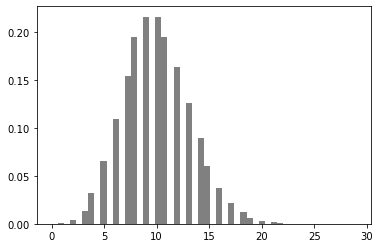

In [16]:
plt.hist(sample, bins = 50, color = 'grey', density = True)
plt.show()

#### Sposób 2.  


Uzasadnienie:  
Dla procesu Poissona z intensywnością $\lambda$ przyrosty pomiędzy chwilami $s$ i $t$ pochodzą z rozkładu $Poiss(\lambda (t-s))$. Iteresuje nas zatem sytuacja gdy $t-s=1$. Aby zrealizować założenie zadania wystarczy zliczyć ile zgłoszeń (międzyczasów) zawiera się w chwili $1$. Kolejne międzyczasy są $i.i.d.$ z rozkładu $Exp(\lambda)$. Zmienną z żądanego rozkładu $Poiss(\lambda)$ jest liczba zdarzeń, które zostaną zgłoszone w międzyczasie długości 1, czyli maksymalne $k$ t.że suma $k$ międzyczasów sumuje się do mniej niż $1$.

In [17]:
def poiss_exp(lamb = 1, N = 1):
    """
    Implementation based on the definition of the Poisson process
    (exponential distribution of subsequent interarrival times)
    """
    
    rand = []
    N = int(N)
    
    while(len(rand) < N):
        count = 0
        total = 0
        while(total < 1):
            # generate exponential random
            X = random.expovariate(lamb)
            
            # update sum of exponential variables
            total += X 
            # update number of exponential variables
            count += 1 
            
            if(total > 1):
                # The count value after the loop break is a Poisson outcome for this trial.
                rand.append(count)

    return rand

In [18]:
lamb = 10
sample = poiss_exp(lamb, N)
np.array(sample)

array([13, 14, 13, ...,  7, 10, 10])

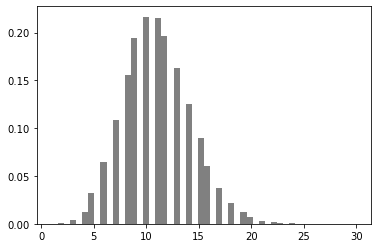

In [19]:
plt.hist(sample, bins = 50, color = 'grey', density = True)
plt.show()

### Zadanie 3.d

Wygeneruj dużo liczb losowych z rozkładu o dystrybuancie
$$
F(x) = \frac{1}{3}F_{b(10, 1/3)}(x) + \frac{1}{3} \Phi(x) + \frac{1}{3}F_{Exp(1)}(x)
$$
Porównaj na wykresie dystrybuantę empiryczną *(ecdf)* z teoretyczną.

In [20]:
def mixed_rand(N):
    
    rand = []
    N = int(N)
    
    # drawing particular distributions with equal probabilities: 1/3 for each
    dist_type = np.random.randint(low = 0, high = 3, size = N)
    binom = len(np.extract(dist_type == 0, dist_type))
    norm = len(np.extract(dist_type == 1, dist_type))
    expon = len(np.extract(dist_type == 2, dist_type))
    
    rand = np.append(rand, np.random.binomial(10, 1/3, binom))
    rand = np.append(rand, np.random.exponential(1, expon))
    rand = np.append(rand, np.random.normal(0, 1, norm))
    
    return rand

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF

sample = mixed_rand(N)

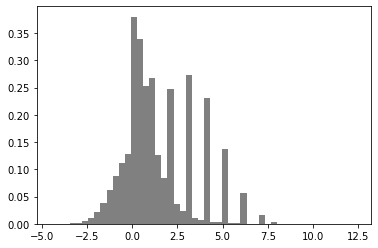

In [22]:
plt.hist(sample, bins = 50, color = 'grey', density = True)
plt.show()

In [23]:
ecdf = ECDF(sample)

In [24]:
def TCDF(x):
    """
    Theoretical CDF function
    """
    result = scipy.stats.binom.cdf(x, 10, 1/3) + scipy.stats.norm.cdf(x, 0, 1) + scipy.stats.expon.cdf(x, 1)
    return result/3

In [25]:
xmin = np.min(sample)
xmax = np.max(sample)

x = np.linspace(xmin, xmax, int(1e5))
tcdf = TCDF(x)
y = tcdf

Text(0.5, 1.0, 'Cumulative distribution functions comparison')

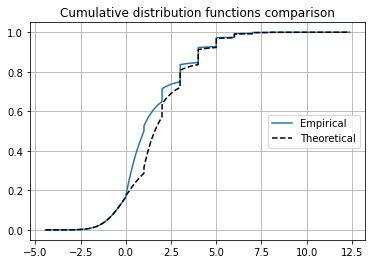

In [26]:
fig, ax = plt.subplots()

ax.plot(ecdf.x, ecdf.y, label='Empirical')
ax.plot(x, y, 'k--', linewidth=1.5, label='Theoretical')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative distribution functions comparison')

### Zadanie 3.e
Poczytaj http://www.cse.yorku.ca/~oz/marsaglia-rng.html i zaimplementuj w Pythonie któryś z opisanych generatororów (np. KISS, czyli Keep it Simple Stupid).  
Kod C można wywoływać w Pythonie na kilka sposobów,https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html, ale ZDECYDOWANIE POLECAM zaprzyjaźnić się z Cythonem. Poświęć chwilę by zrozumieć jaka jest idea za generatorami KISS.  
Porównaj szybkość generowania z wbudowanym generatorem w Pythonie oraz z generatorem liniowym.  

In [27]:
%load_ext cython

In [28]:
%%cython

cdef class JKISS:
    cdef unsigned int x, y, z, c
    
    def __cinit__(self, x = 123456789, y = 987654321, z = 43219876, c = 6543217):
        self.x = x
        self.y = y
        self.z = z
        self.c = c
        

    def generate(self):
        cdef unsigned long long t
    
        self.x = 314527869 * self.x + 1234567
        self.y ^= self.y << 5
        self.y ^= self.y >> 7
        self.y ^= self.y << 22
    
        t = 4294584393ULL * self.z + self.c
        self.c = t >> 32
        self.z = t
    
        return (self.x + self.y + self.z)

In [29]:
generator = JKISS()
sample = np.array([generator.generate()/4294967296.0 for i in range(N)])
sample

array([0.13044139, 0.60596866, 0.59193787, ..., 0.09278355, 0.26264371,
       0.53031223])

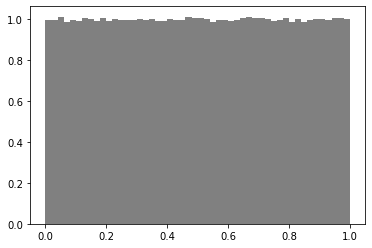

In [30]:
plt.hist(sample, bins = 50, color = 'grey', density = True)
plt.show()

In [31]:
import time

def time_comp(func, span):
    """
    Computes execution times for each generator
    returning single values
    """
    times = []
    for N in span:
        start_time = time.time()
        [func() for i in range(int(N))]
        times.append(time.time() - start_time)
    return times

def time_comp_vec(func, span):
    """
    Computes execution times for each generator
    returning vectors of values
    """
    times = []
    for N in span:
        start_time = time.time()
        func(int(N))
        times.append(time.time() - start_time)
    return times

In [32]:
# N range
span = np.arange(0, 1e5+1, 5e3)
span[0] = 1

In [33]:
# Linear generator
linear = time_comp_vec(LCG, span)

In [34]:
# Built-in Python generator
builtin = time_comp(np.random.random, span)

In [35]:
# JKISS generator
jkiss = time_comp(generator.generate, span)

Text(0.5, 1.0, 'Execution times comparison')

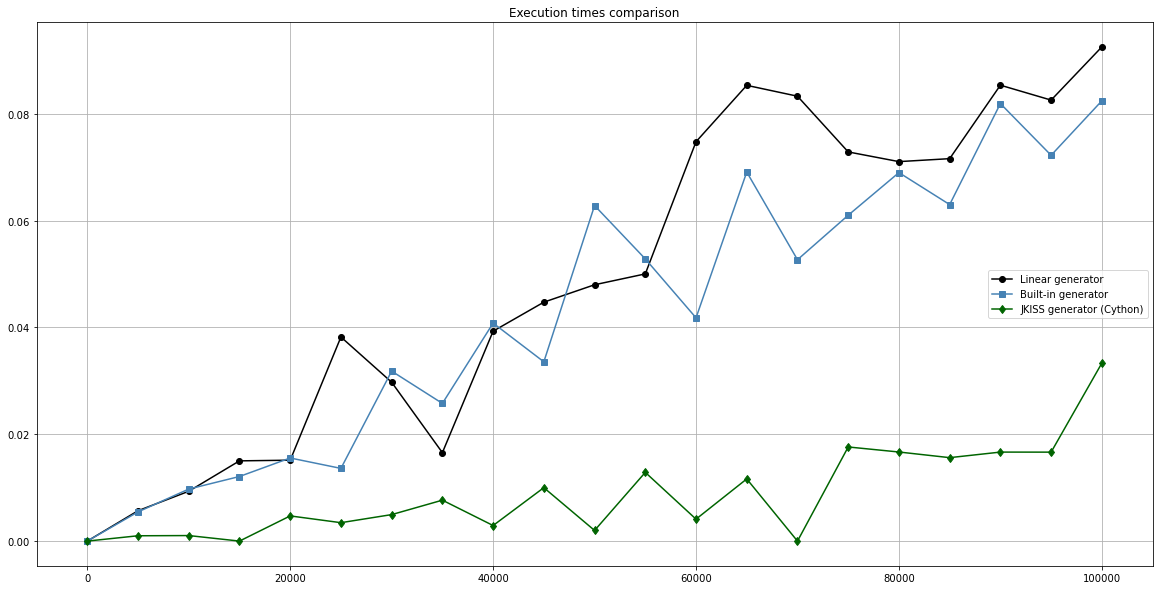

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(span, linear, '-ok', label='Linear generator', color='black')
ax.plot(span, builtin, '-sk', linewidth=1.5, label='Built-in generator',  color='steelblue')
ax.plot(span, jkiss, '-dk', linewidth=1.5, label='JKISS generator (Cython)', color = 'darkgreen')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Execution times comparison')

In [37]:
# Pure Python implementation - implemented to better understanding of the idea behind KISS generators
def KISS(N):

    """
    Congruential generator - generates N values
    starting from initial random value 
    """
    N = int(N)
    
    CONG = np.zeros(N)
    CONG[0] = round(np.random.uniform()*(2**32))

    for i in range(1, N):
        CONG[i] = (69069 * CONG[i-1] + 1234567)%(2**32)
        
    
    """
    Multiply-with-carry generator - generates N values
    starting from two initial random values  
    """
    MWC = np.zeros(N)
    z = round(np.random.uniform()*(2**32))
    w = round(np.random.uniform()*(2**32))

    for i in range(N):
        z = 36969 * (z & 65535) + (z >> 16)
        w = 18000 * (z & 65535) + (w >> 16)
        MWC[i] = ((z << 16) + w)%(2**32)

    """
    KISS generator takes values generated with the above CONG 
    and MWC generators and combines them with the 3-shift register 
    SHR3 using addition and exclusive-or.
    """
    KISS = np.zeros(N)
    SHR3 = np.zeros(N)

    for i in range(N):
        JSR = round(np.random.uniform()*(2**32))
        JSR ^= (JSR << 17)  
        JSR ^= (JSR >> 13)  
        JSR ^= (JSR << 5) 
        SHR3[i] = JSR

    res = (np.bitwise_xor(MWC.astype(np.int64), CONG.astype(np.int64)) + SHR3)%(2**32)
    return res

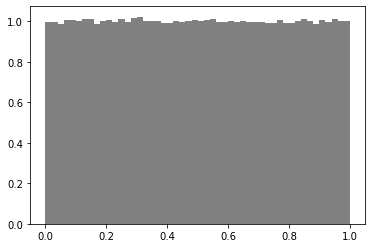

In [38]:
sample = KISS(N)/4294967296.0 
plt.hist(sample, bins = 50, color = 'grey', density = True)
plt.show()

In [39]:
# KISS generator
kiss = time_comp_vec(KISS, span)

Text(0.5, 1.0, 'Execution times comparison')

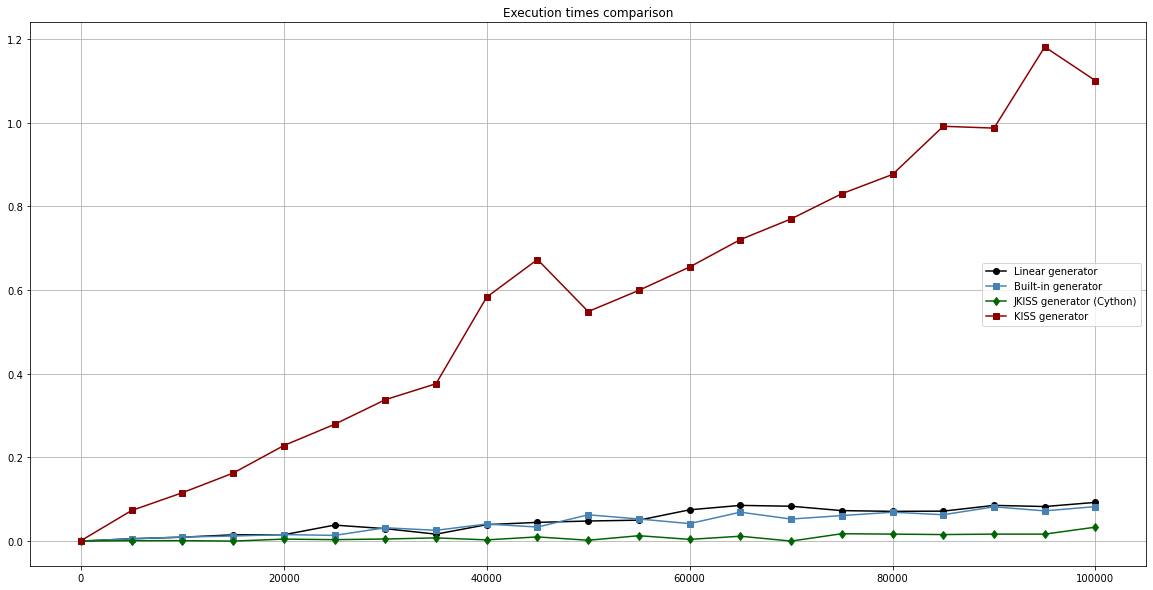

In [40]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(span, linear, '-ok', label='Linear generator', color='black')
ax.plot(span, builtin, '-sk', linewidth=1.5, label='Built-in generator',  color='steelblue')
ax.plot(span, jkiss, '-dk', linewidth=1.5, label='JKISS generator (Cython)', color = 'darkgreen')
ax.plot(span, kiss, '-bs', linewidth=1.5, label='KISS generator', color = 'darkred')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Execution times comparison')